In [ ]:
!pip install fastaudio

In [ ]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

/usr/local/lib/python3.8/dist-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [ ]:
# This notebook runs on colab , if u want to run it on kaggle , dont run the following and change the file paths 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omarrelsayeed","key":"84cd0f75c3c41cee1a62085bfc72eacc"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c nuaih-age-capturing-from-speech-signals

 99% 793M/802M [00:07<00:00, 109MB/s]
100% 802M/802M [00:07<00:00, 109MB/s]


In [ ]:
!unzip /content/nuaih-age-capturing-from-speech-signals.zip -d /content/alldataset

In [ ]:
import os
audio_path = os.listdir("/content/alldataset/Age_Through_Speech/Age_Through_Speech/one_and_multiple/")

In [ ]:
df = pd.read_csv("/content/alldataset/Age_Through_Speech/Age_Through_Speech/train.csv")
df = pd.concat([df , pd.read_csv("/content/alldataset/Age_Through_Speech/Age_Through_Speech/test.csv")])

In [ ]:
audio_paths = pd.DataFrame(audio_path)

In [ ]:
audio_paths['Age'] = audio_paths[0].apply(lambda x :  df[df['Subject'] == int(x.split("_")[2])]['Age'].values[0])

In [ ]:
test_set = audio_paths[audio_paths['Age'].isnull()]

In [ ]:
train_set = audio_paths[audio_paths['Age'].notnull()]

In [ ]:
train_set.reset_index(drop = True , inplace=True)

In [ ]:
train_set.columns = ["filename" , "Age"]

In [ ]:
train_set

,filename,Age
0,S_01_4317_VE.wav,22.0
1,S_02_4387_VV1.wav,23.0
2,S_01_4398_VE1.wav,17.0
3,S_02_4001_VE1.wav,19.0
4,S_01_4267_VE.wav,30.0
...,...,...
2753,S_02_4581_VE2.wav,18.0
2754,S_01_4032_VV.wav,57.0
2755,S_02_4282_VE5.wav,18.0
2756,S_02_4623_VV2.wav,24.0


In [ ]:
# Helper function to split the data
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [ ]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [ ]:
a2s

AudioToSpec:
encodes: (AudioTensor,object) -> encodes
decodes: 

In [ ]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)
aud2spec = DBMelSpec(n_mels=128, f_max=10000, n_fft=1024, hop_length=128, top_db=100)

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [ ]:
item_tfms = [RemoveSilence(), ResizeSignal(4000), aud2spec, MaskTime(size=4), MaskFreq(size=10)]

In [ ]:
auds = DataBlock(blocks = (AudioBlock, RegressionBlock()),  
                 get_x = ColReader("filename", pref=Path("/content/alldataset/Age_Through_Speech/Age_Through_Speech/one_and_multiple")), 
                #  splitter = CrossValidationSplitter(fold=1),
                 item_tfms = item_tfms,
                 get_y = ColReader("Age"))

In [ ]:
dbunch = auds.dataloaders(train_set, bs=64 )

In [ ]:
!pip install timm

In [ ]:
from timm.models.convnext import convnext_tiny

In [ ]:
learn = cnn_learner(dbunch, 
            convnext_tiny,
            n_in=1,  # <- This is the only audio specific modification here
            loss_func=MSELossFlat())

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.03981071710586548)

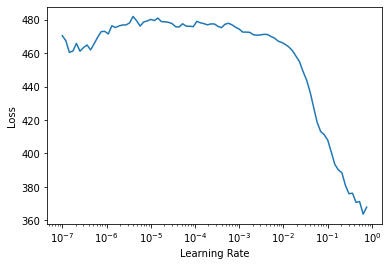

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fine_tune(10 , 1e-2)

epoch,train_loss,valid_loss,time
0,473.447418,438.241302,00:53


epoch,train_loss,valid_loss,time
0,463.323425,433.593079,02:29
1,455.567352,425.089203,02:27
2,447.365540,405.511414,02:27
3,429.785736,373.224762,02:26
4,409.165375,348.523315,02:25
5,383.377106,322.812988,02:25
6,356.962341,296.197968,02:28
7,336.989105,291.572662,02:27
8,323.608643,287.348541,02:27
9,313.868042,283.918060,02:26


In [ ]:
ss = pd.read_csv("/content/alldataset/Sample Submission.csv")

In [ ]:
test_set[0]=test_set[0].apply(lambda x : "/content/alldataset/Age_Through_Speech/Age_Through_Speech/one_and_multiple/" + x )

<ipython-input-218-e715aa84e93a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[0]=test_set[0].apply(lambda x : "/content/alldataset/Age_Through_Speech/Age_Through_Speech/one_and_multiple/"+x)


In [ ]:
test_set.reset_index(drop=True , inplace=True)

In [ ]:
tst_files = test_set[0].tolist()
tst_dl = dbunch.test_dl(tst_files).to("cuda")

In [ ]:
results = learn.get_preds(dl=tst_dl)

In [ ]:
results = results[0].numpy().reshape((1206))

In [ ]:
test_set['Age'] = pd.Series(results, name="Age")

<ipython-input-223-d2f11af0c317>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Age'] = pd.Series(results, name="Age")


In [ ]:
test_set[0] = test_set[0].apply(lambda x : int(x.split("_")[8]))

<ipython-input-224-7113c6d6e91d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[0] = test_set[0].apply(lambda x : int(x.split("_")[8]))


In [ ]:
test_set.columns = ['Subject' , "Age"]

In [ ]:
grouped = test_set.groupby("Subject")["Age"].mean()


In [ ]:
df_mean_age = grouped.reset_index()
print(df_mean_age)

     Subject        Age
0       4697  19.877579
1       4699  21.697021
2       4702  20.881420
3       4706  20.726866
4       4708  21.113817
..       ...        ...
152     4993  21.030836
153     4994  21.285852
154     4995  20.471735
155     4998  21.985088
156     4999  19.857628

[157 rows x 2 columns]


In [ ]:
df_mean_age.to_csv("subm.csv" , index = False)